# Model analytics


A model has a well defined logical and causal structure.{cite:author}`kogiku_introduction_1968`provides an introduction to causal analysis of models can be found in {cite:author}`kogiku1968`(1968), while {cite:author}`berndsen_causal_1995` provides a more elaborate discussion. 

At the simplest level, the equations of a model can be organized into blocks. 

* **Simultaneous block** include equations that have are co-determined simultaneously. They contain feedback loops that mean they may require several iterations before a solution that satisfies them all is found. A classic simultaneous block would include GDP and Consumption. Consumption depends on income. Income depends on GDP, but COnsumption determines GDP. 

* **Recursive blocks** include equations that are a simple function of other variables. For example, the current account balance is just the difference between Export Revenues and Import Revenues.  These can be solved with just one pass once the values of the simultaneous blocks have been resolved.


At the equation level, each endogenous variable is a function of one or more variables, but because these variables are also dependent on other variables in the model, those right hand side variables that are endogenous can have their equations substituted into the first level equation to get an extended set of dependencies and he endogenous right hand side variables of these second level variables can also have their right hand sides substituted into the equation etc.


`Modelflow` uses the [networkx](https://networkx.org/) python package to analyze the interrelation ships within the model and between equations and includes a number of methods and properties to present these interrelationships both in tabular and graphical form [^Graphvix], a subset of which is exposed in this chapter. 

[^Graphviz]: The relational graphs produced by `modelflow` use the [Graphviz](https://graphviz.org/) program, and are based on the relationships determined by the Networkx package. 

Setting up the python environment and loading a pre-exisitng model

In [67]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')
  incolab = True  
else:
  incolab = False 

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from modelclass import model

latex = True    # Setting to allow the diagrams to be incorporated in latex

mpak,baseline = model.modelload('../models/pak.pcim',alfa=0.7,run=1)

mpak.model_description="World Bank climate aware model of Pakistan as described in Burns et al. (2019)"
mpak.model_description
mpak.periode=2100

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


## Model information

The model object contains information about the model itself, its name, its structure (does it contain simultaneous equations or is it recursive), the number of variables it contains and the number that are exogenous and endogenous (have associated equations).

In [69]:
mpak

<
Model name                              :                  PAK 
Model structure                         :         Simultaneous 
Number of variables                     :                  839 
Number of exogeneous  variables         :                  461 
Number of endogeneous variables         :                  378 
>

The model work space also has a time dimension, its sample period. This can be retrieved and changed.

`mpak.per_current'

In [70]:

mpak.current_per

Index([2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027,
       2028, 2029, 2030],
      dtype='int64')

## Model structure  

A quick way to visualize the structure of a model is to plot its [adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). 

The adjacency matrix plots the relationships between endogenous variables in the model, dividing them into one or more simultaneous blocks and one or more recursive blocks.

Below is the adjacency matrix for the Pakistan model. Variables in the red square block depend on one or more variables that in turn depends upon them, requiring the mode to solve for their values simultaneously.  The variables in the green triangles do not enter directly or indirectly as an argument in the variables that determine them and therefore can be solved in one iteration once the values for the simultaneous variables are determined.

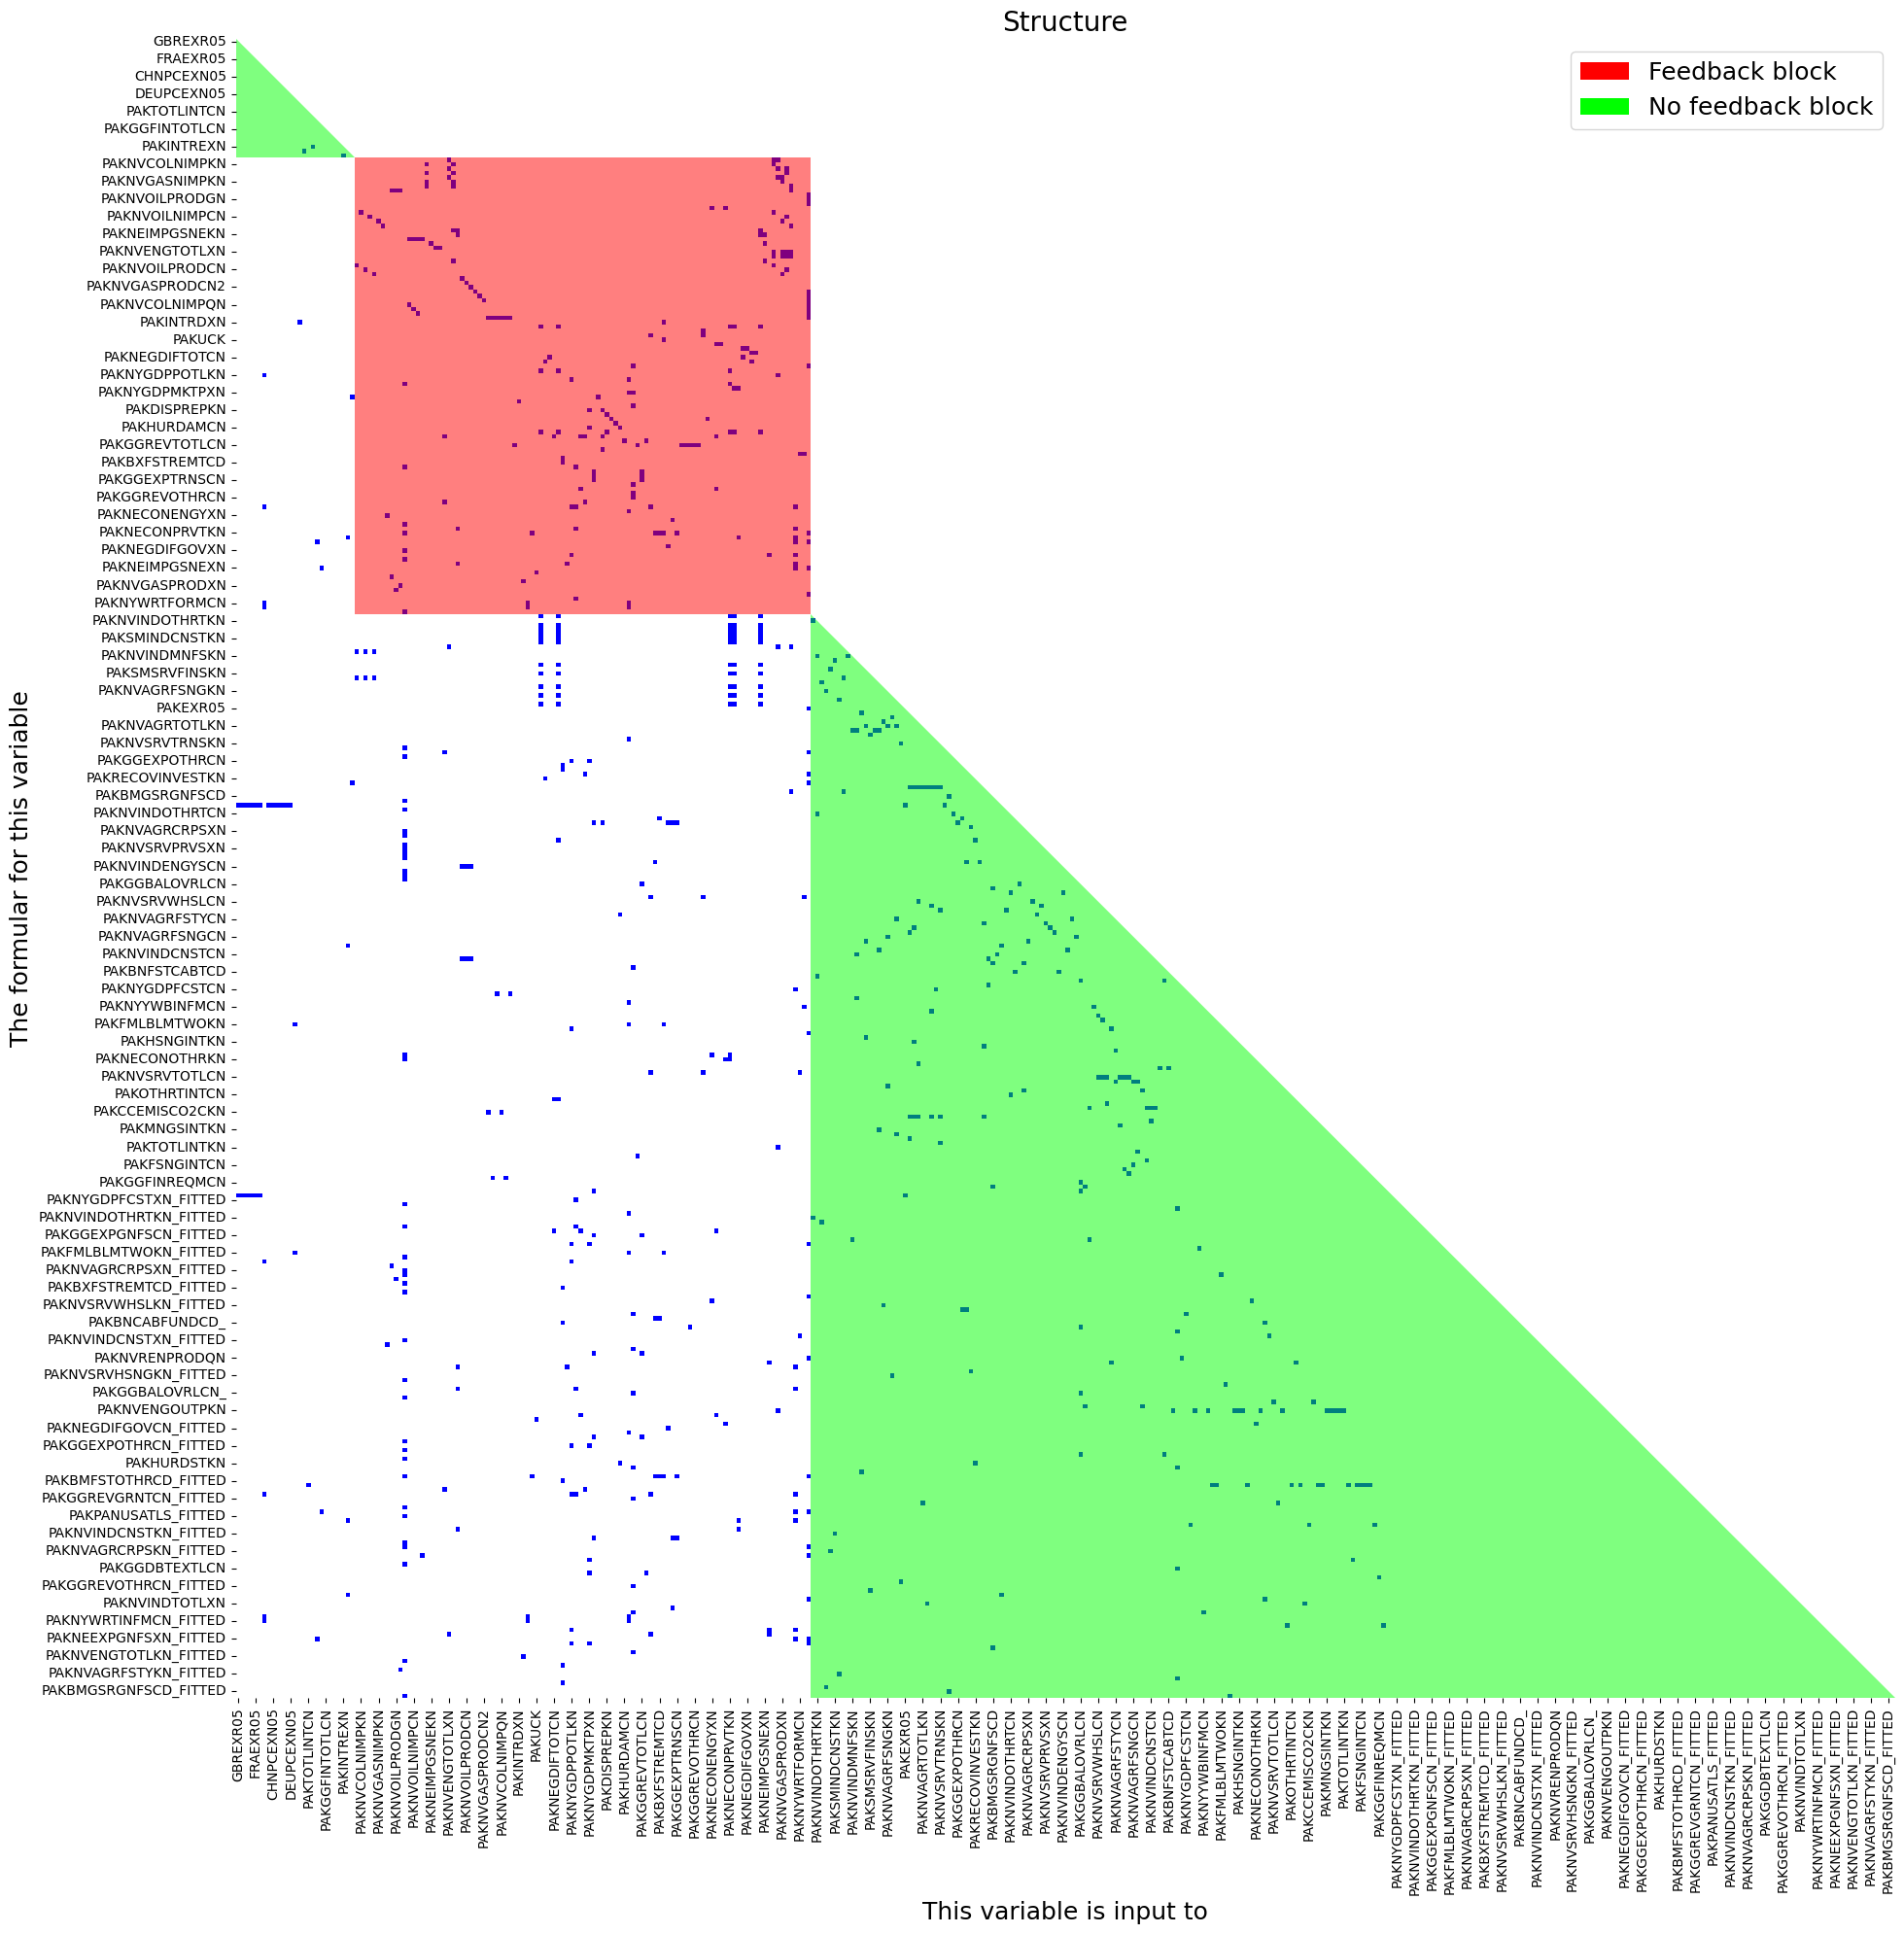

In [71]:
mpak.plotadjacency(size=(20,20),nolag=0);

# The dependencies of individual endogenous variables (the `.tracepre()`  and `.tracedep()`methods)

As noted above, every endogenous variables is directly dependent on the variables that occur on its right hand side (RHS), but is also indirectly dependent on the variables that determine its RHS variables and in turn those that determine the variables to the right of them *ad infinitum*. 

`Modelflow` includes several methods and properties that allow these dependencies to be explored.

The `.frml` property returns the normalized formula of an equation, from which the right hand variables for the equation can be discerned.

In [72]:
mpak.PAKNECONPRVTKN.frml

Endogeneous: PAKNECONPRVTKN: HH. Cons Real
Formular: FRML <DAMP,STOC> PAKNECONPRVTKN = (PAKNECONPRVTKN(-1)*EXP(PAKNECONPRVTKN_A+ (-0.2*(LOG(PAKNECONPRVTKN(-1))-LOG(1.21203101101442)-LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1)))+0.763938860758873*((LOG((((PAKBXFSTREMTCD-PAKBMFSTREMTCD)*PAKPANUSATLS)+PAKGGEXPTRNSCN+PAKNYYWBTOTLCN*(1-PAKGGREVDRCTXN/100))/PAKNECONPRVTXN))-(LOG((((PAKBXFSTREMTCD(-1)-PAKBMFSTREMTCD(-1))*PAKPANUSATLS(-1))+PAKGGEXPTRNSCN(-1)+PAKNYYWBTOTLCN(-1)*(1-PAKGGREVDRCTXN(-1)/100))/PAKNECONPRVTXN(-1))))-0.0634474791568939*DURING_2009-0.3*(PAKFMLBLPOLYXN/100-((LOG(PAKNECONPRVTXN))-(LOG(PAKNECONPRVTXN(-1)))))) )) * (1-PAKNECONPRVTKN_D)+ PAKNECONPRVTKN_X*PAKNECONPRVTKN_D  $

PAKNECONPRVTKN  : HH. Cons Real
DURING_2009     : 
PAKBMFSTREMTCD  : Imp., Remittances (BOP), US$ mn
PAKBXFSTREMTCD  : Exp., Remittances (BOP), US$ mn
PAKFMLBLPOLYXN  : Key Policy Interest Rate
PAKGG

The method `.tracepre()` provides a graphical representation of this relationship, showing all the variables that directly determine an endogenous variable (in this example real GDP), distinguishing between RHS variables that are endogenous (in blue) and those that are exogenous (yellow).

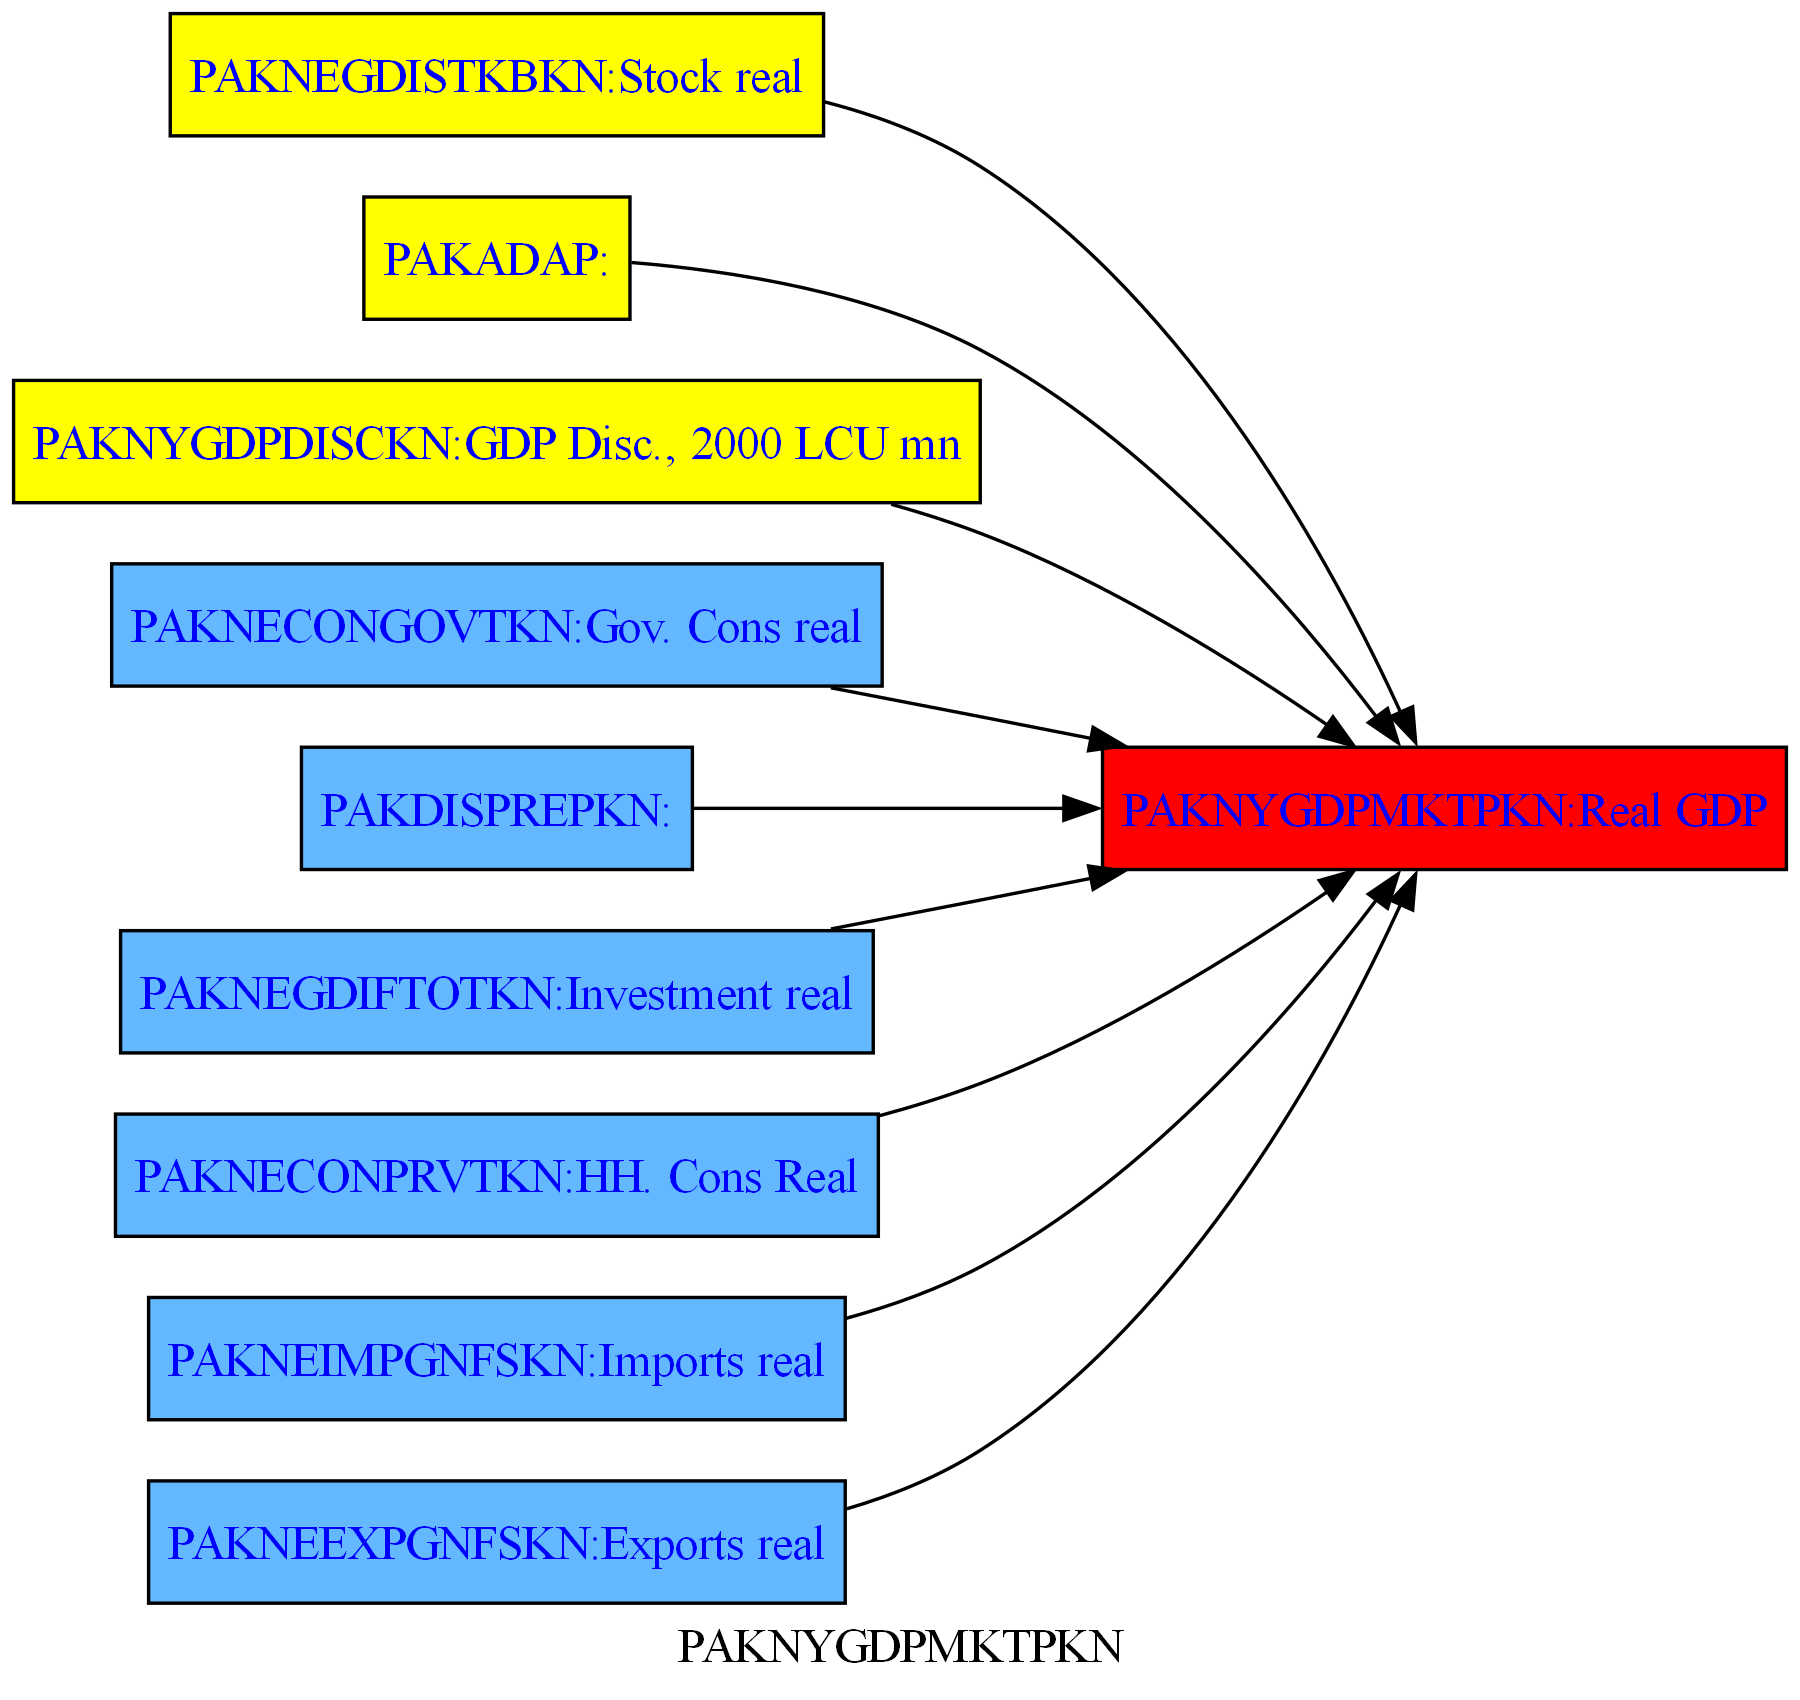

In [73]:
mpak.PAKNYGDPMKTPKN.tracepre(png=latex)

If the model has been solved, `.pretrc()` goes one step further and reveals the relative imortance of each variable in the change of the dependent variable.

## Shock the model

Below a $30 nominal Carbon tax is applied beginning in 2025.

In [74]:

alternative  =  baseline.upd("<2025 2100> PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER = 30")
result = mpak(alternative,2020,2100) # simulates the model 

As a result GDP, consumption investment and most all variables in the model change, as illustrated in the below graphs that show the percent deviation of the main components of GDP from their baseline values.

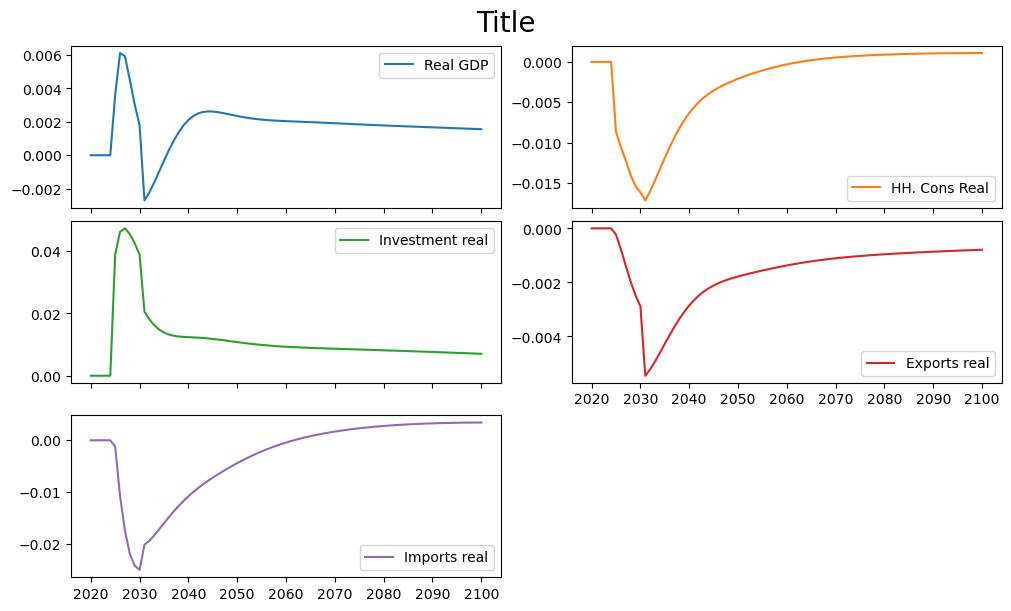

In [75]:
mpak['PAKNYGDPMKTPKN PAKNECONPRVTKN PAKNEGDIFTOTKN PAKNEEXPGNFSKN PAKNEIMPGNFSKN'].difpctlevel.rename().plot()

## Post shock `.tracepre()` indicates the relative importance of different variables in explaining the change in the dependent variable

Below the same command is executed, but because of the shock, the width of the lines indicating representing the causal links between variables is ticker the more important a given variable was in the previous simulation in explaining the change in the level of the dependent variable (GDP).  

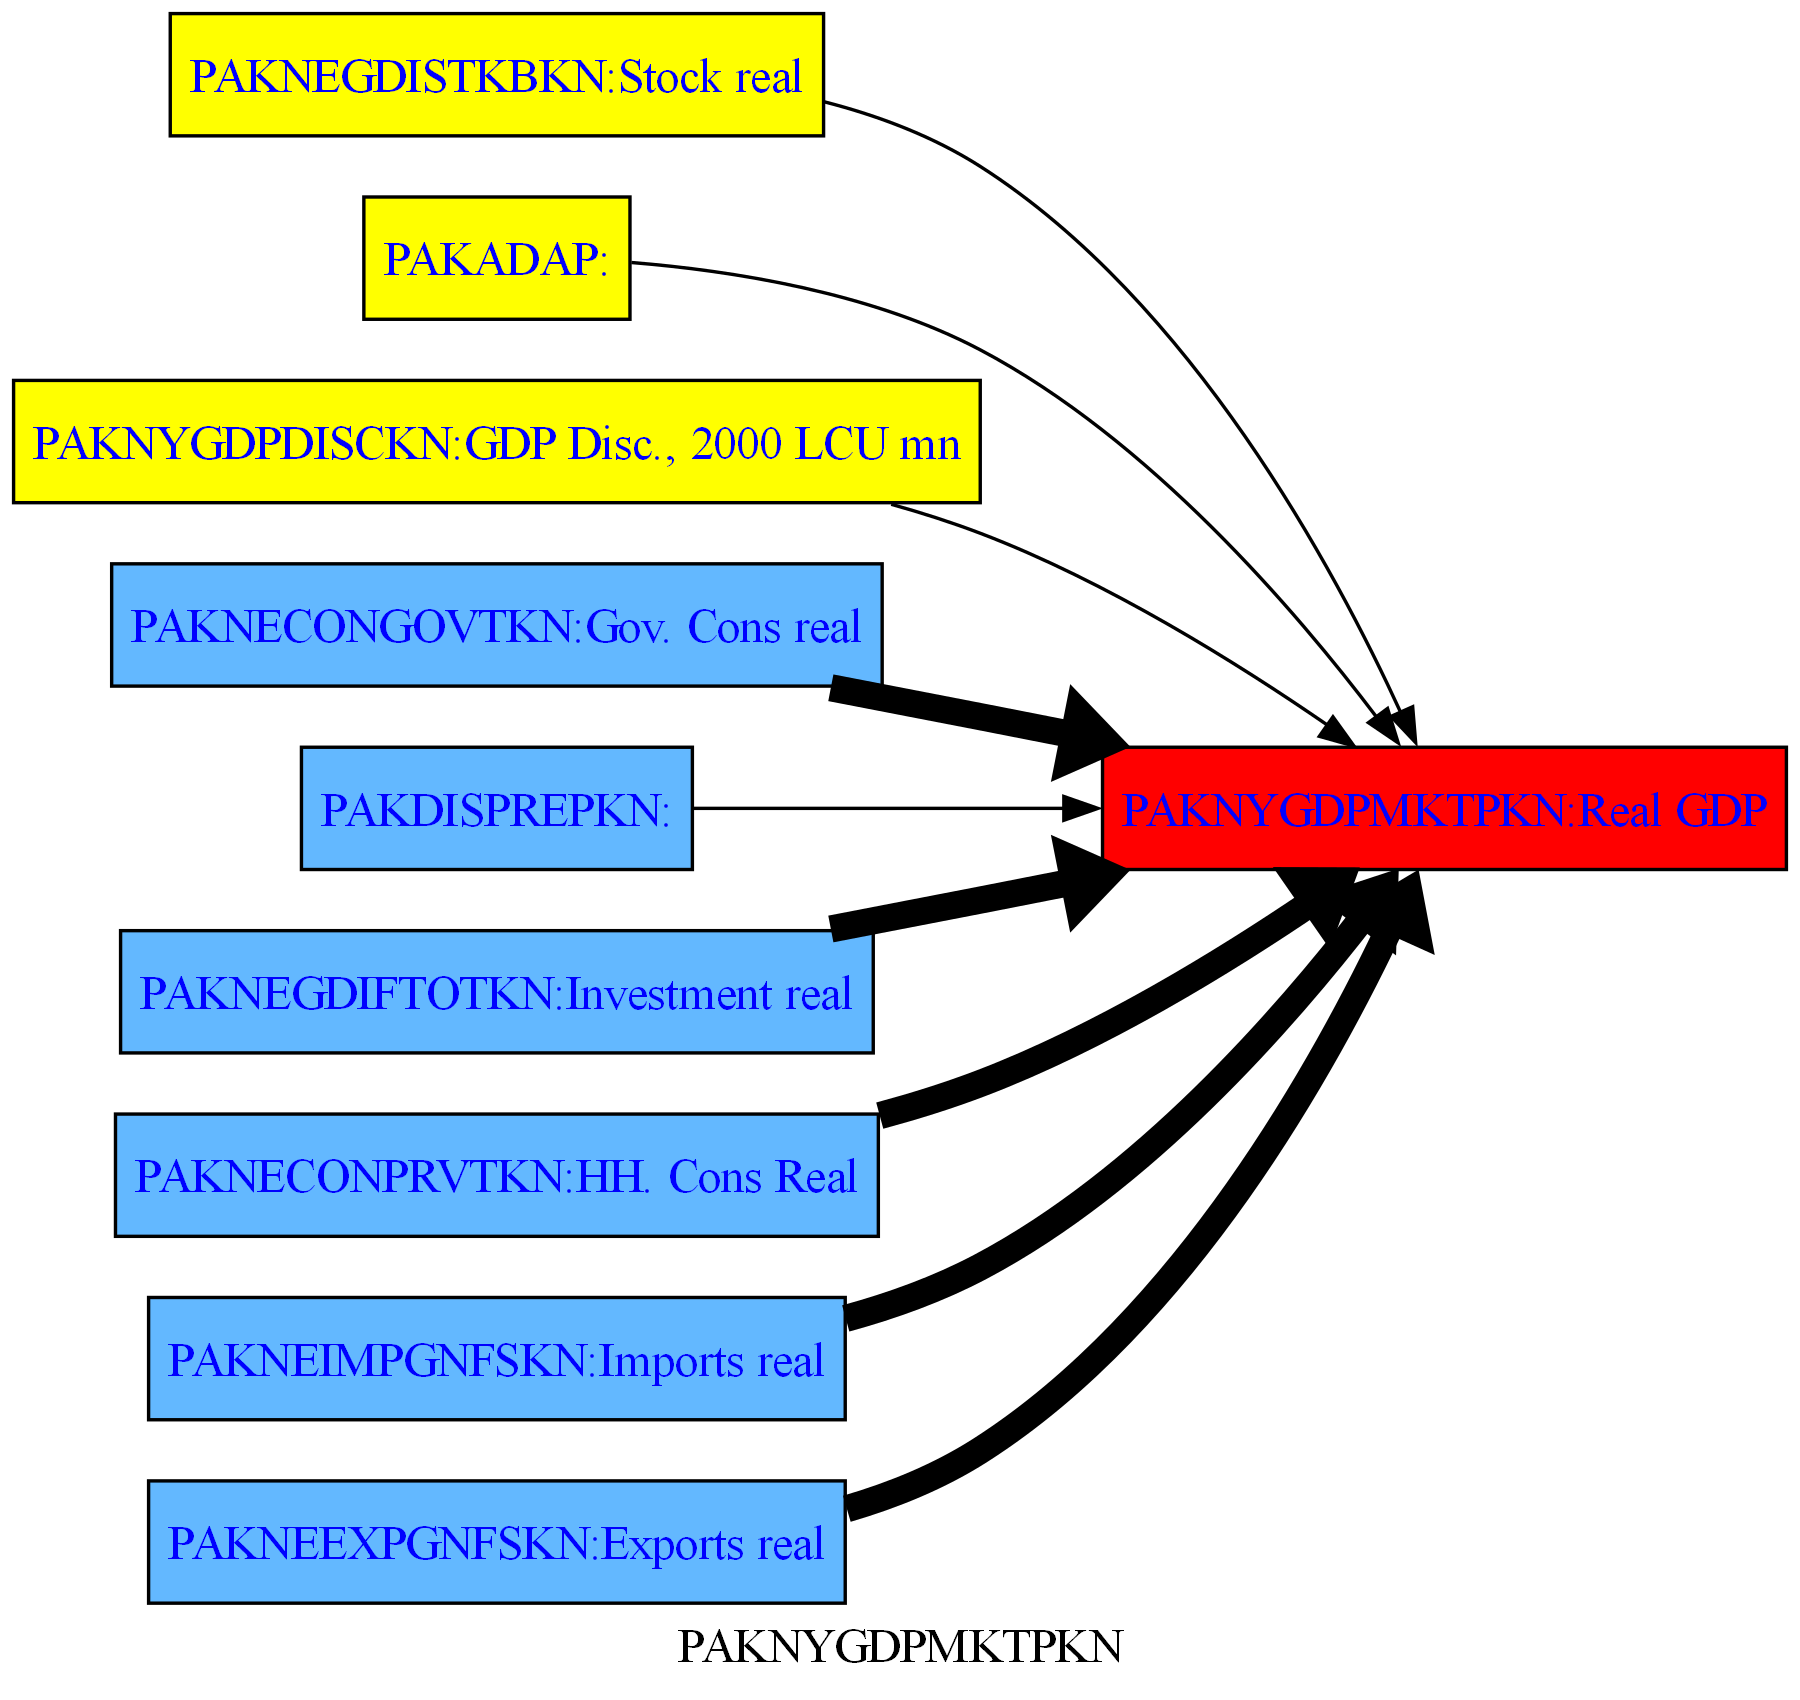

In [76]:
mpak.PAKNYGDPMKTPKN.tracepre(png=latex)

:::{note}
**png=latex** 

The default behavior when displaying graphs in a *jupyter notebook* is to produce images in .svg format.
These images scale well and the mouseover feature can be used. That is: On mouseover of a node, the variable and the equation are displayed.  On mouseover on an joining line, the extent to which the variable contributed to the change in the dependent variable is displayed.

Unfortunately this *jupyter book* (that is not a notebook) requires images be in  jpg or PNG format so this functionality has been disabled, by specifying that the png format be used instead of svg.

For other purposes, the variable latex could be set equal to False in which case the same code will generate SVGs. In this case you can use the mouse to hover over elements to get descriptions
:::

### The filter option, restricting the output of `.tracepre()`

Using the filter option, the output of `.tracepre()` can be restricted to RHS variables that have had large impacts on the dependent variable.v


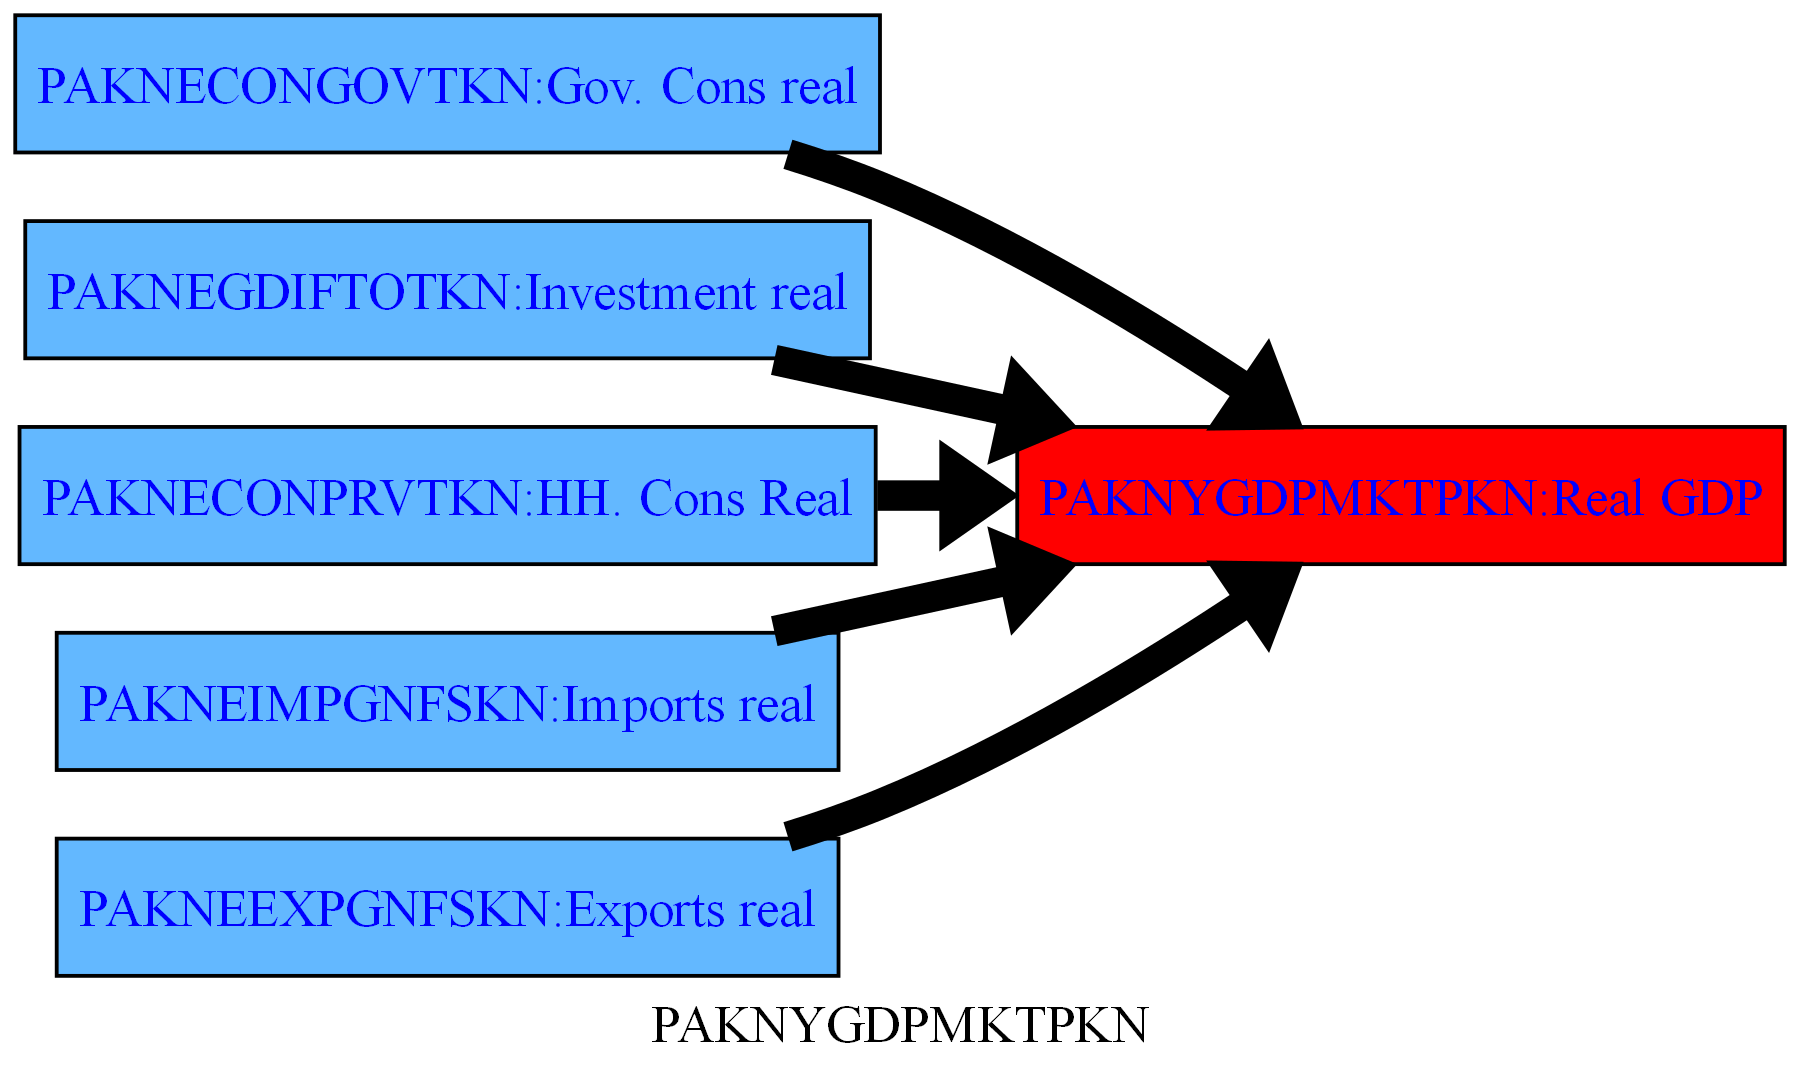

In [77]:
gg=mpak.PAKNYGDPMKTPKN.tracepre(filter=20,png=latex)
gg

### The up option, extending the `.tracepre` beyond the first level causal variables

The up option allows `.tracepre` dependencies to be followed through beyond the first level of causal variables.  Below it is extended to variables as much as three levels back, and restricted to those whose variation explains at least 20 percent of the change in GDP.

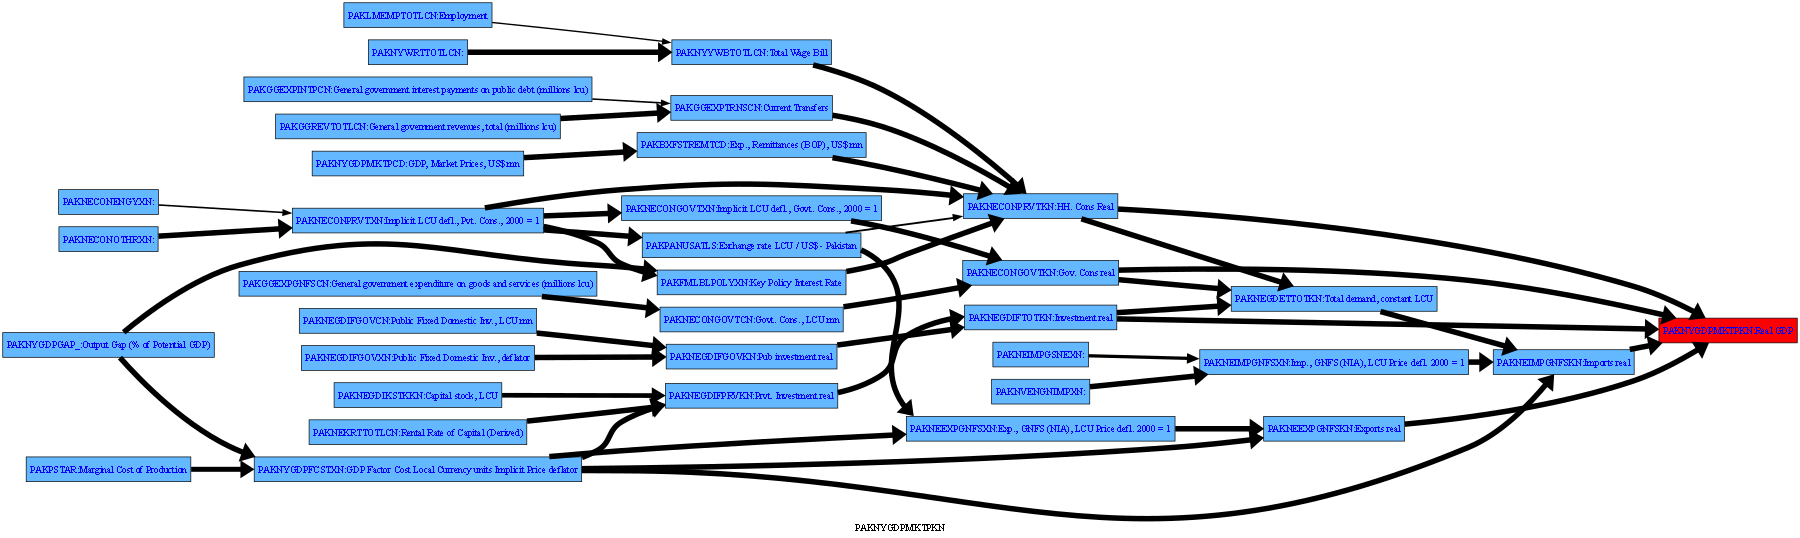

In [78]:
mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,up=3,png=latex,)

### The Focus2all=True  option  adds values to each node 

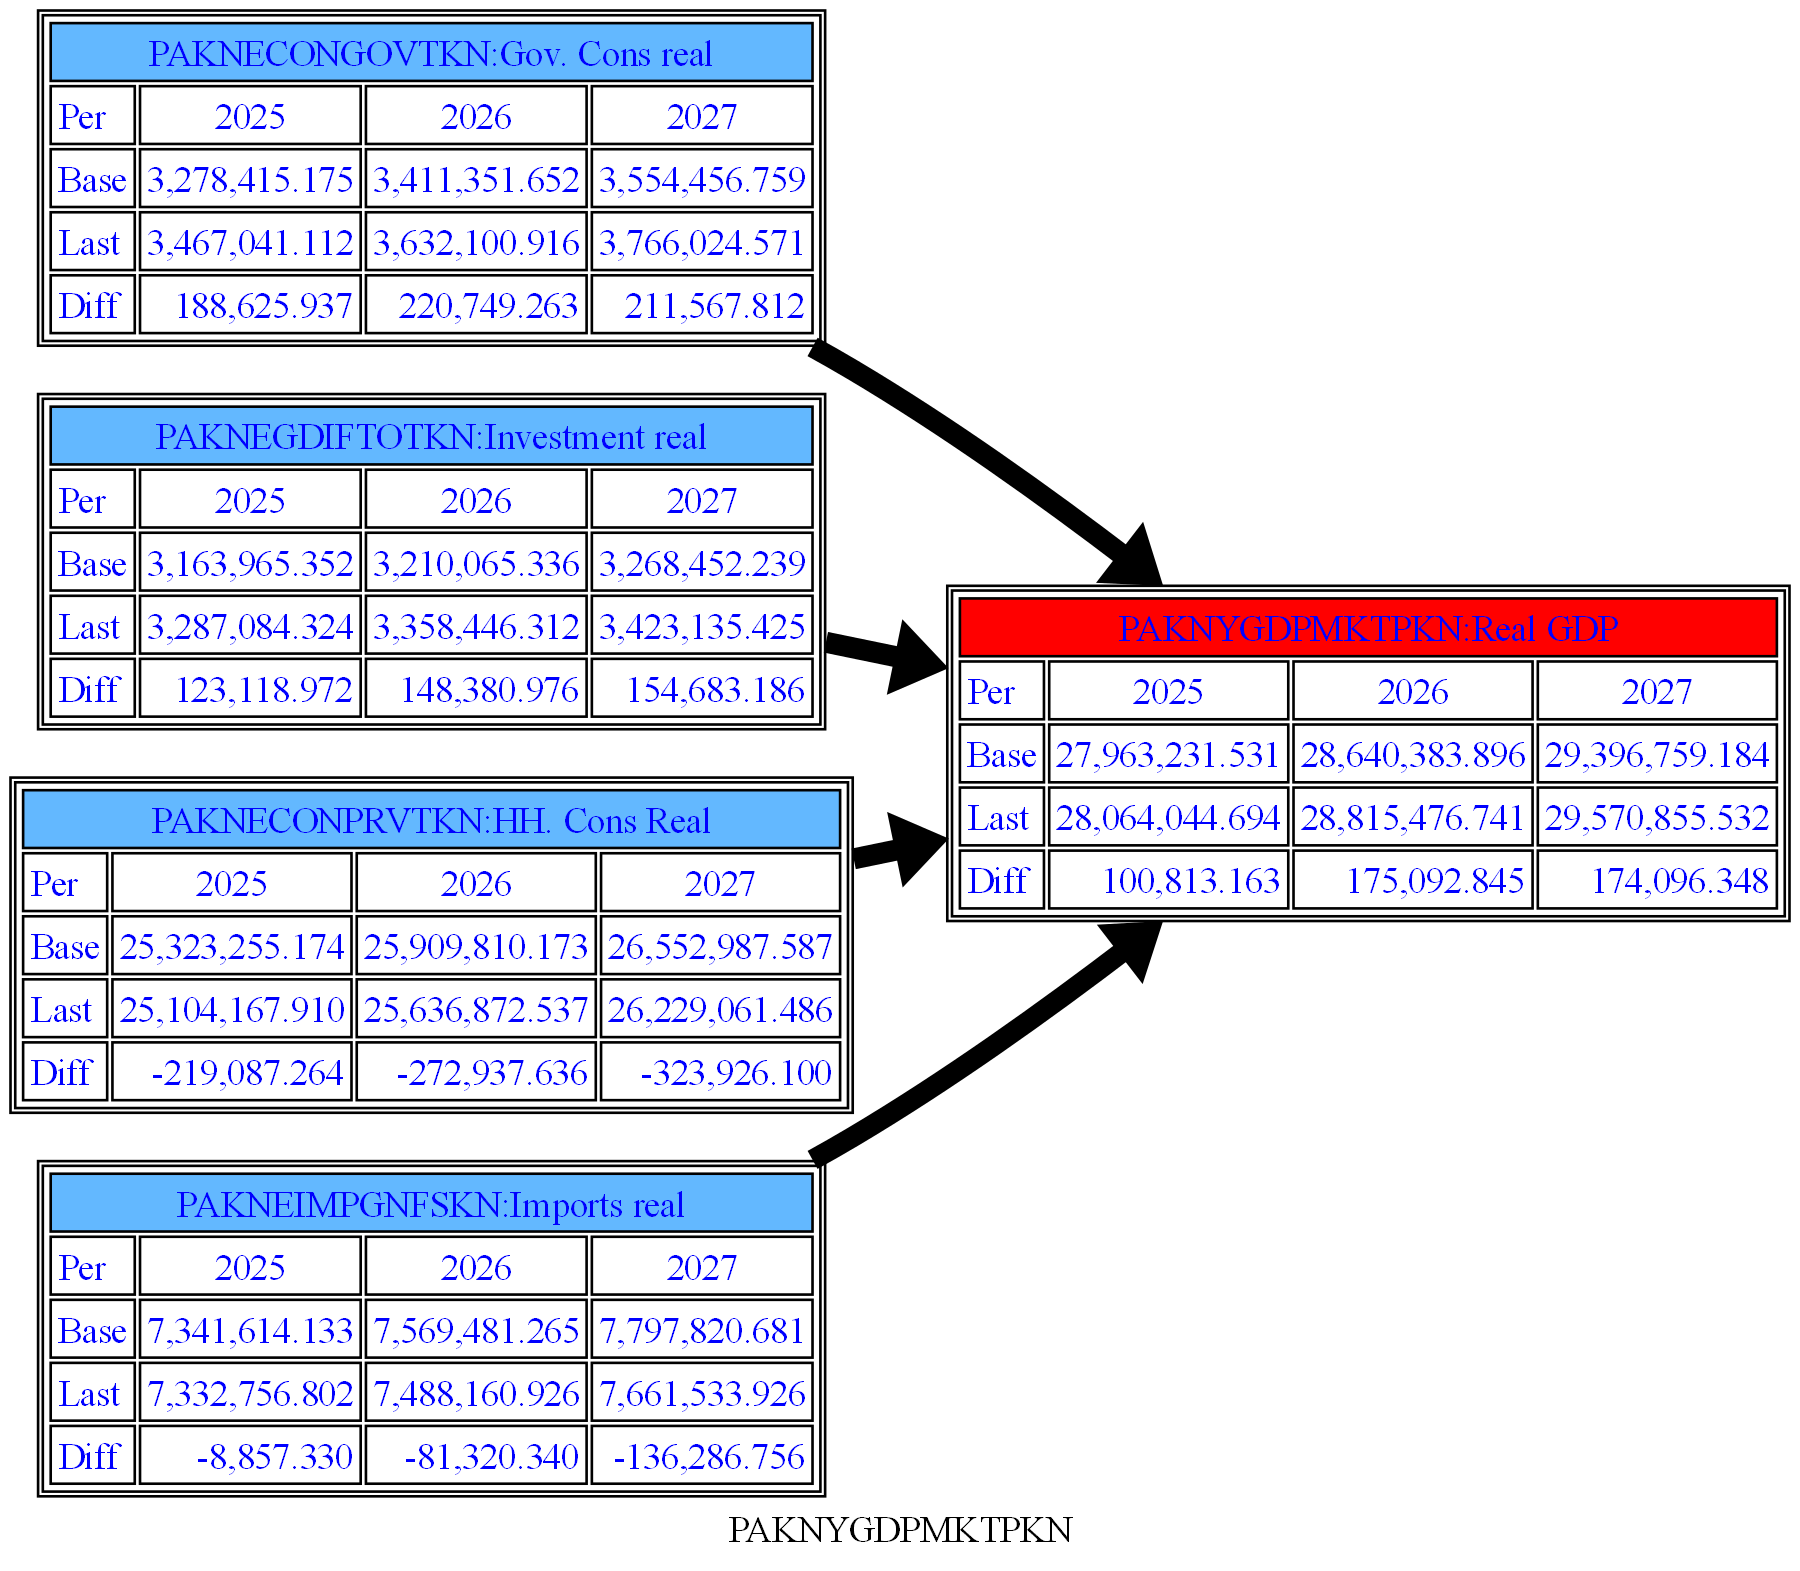

In [79]:
with mpak.set_smpl(2025,2027):
    mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,fokus2all=True,png=latex)

### attshow=True and growthshow=True adds additional information to each node

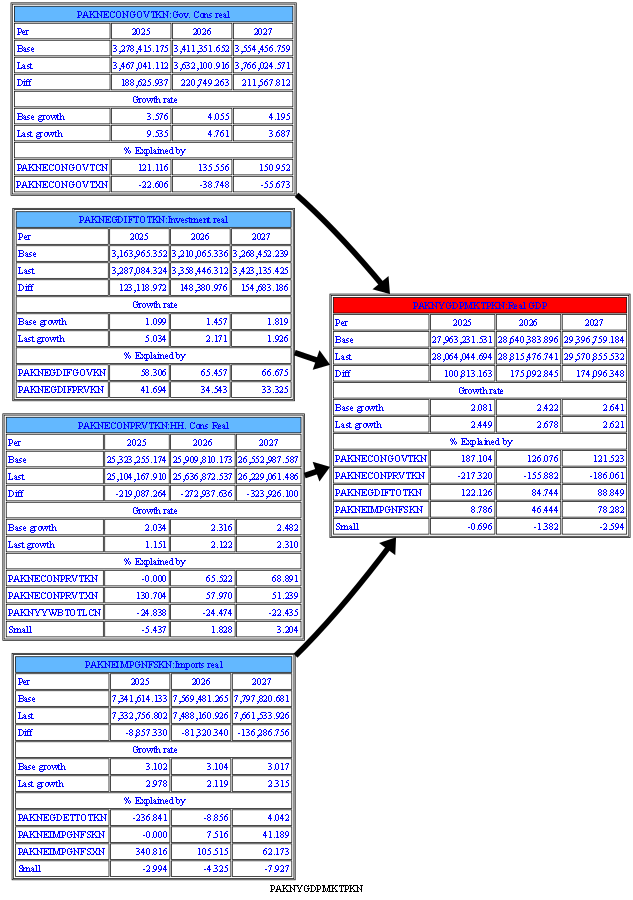

In [86]:
with mpak.set_smpl(2025,2027):
    mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,                                 
                                 fokus2all=True,
                                 attshow=True,
                                 growthshow = True,
                                png=latex,size=(3,3))

### fokus2='variables ...' allows narrowing the variables to display

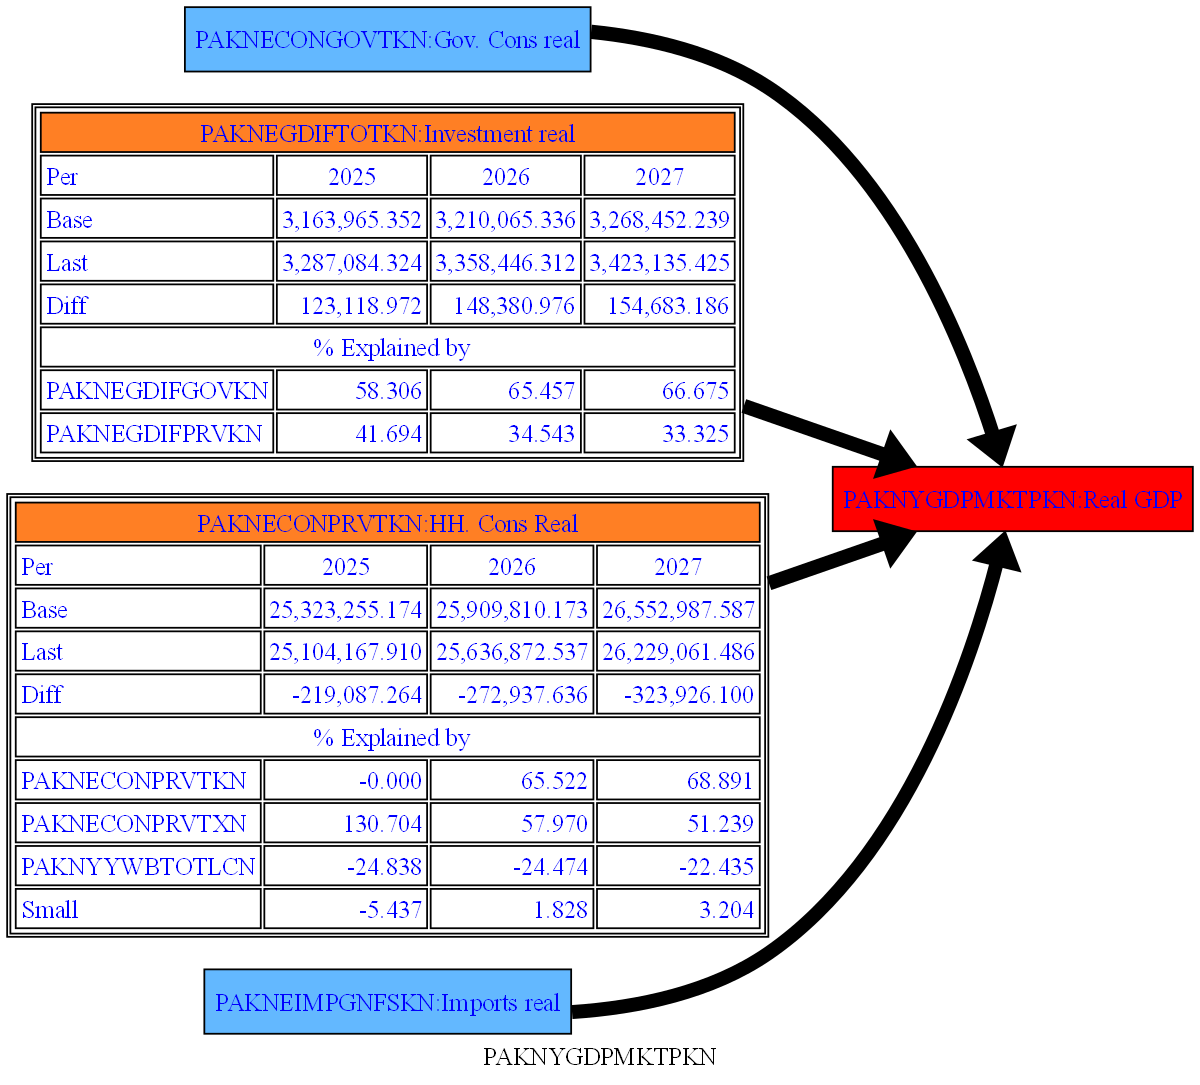

In [87]:
with mpak.set_smpl(2025,2027):
    mpak.PAKNYGDPMKTPKN.tracepre(filter = 20,                                 
                                 fokus2='PAKNEGDIFTOTKN PAKNECONPRVTKN',
                                png=1,svg=1,pdf=1,attshow=1,size=(4,4))

In addition:
 - `svg = True` will output the graph into a svg file in the graph\ subfolder
 - `pdf = True` will output the graph into a pdf file in the graph\ subfolder
 
 Both these formats have the benefits of allowing zooming without becoming coarse. This is useful if the the output 
 becomes busy. 
 
 Also the svg format allows hovering with the mouse. 

## Post shock `.tracedep` traces the impact of a variable on other variables 
The same options can be used as for `.tracepre`

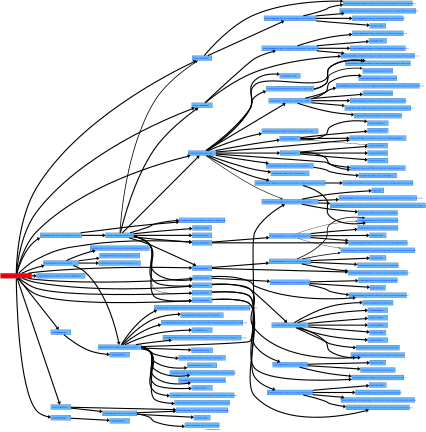

In [82]:
mpak.PAKNECONPRVTKN.tracedep(down=3,filter=20)

# `.modeldash()` An interactive way to explore dependencies and attributions


The `.modeldash()` method (when executed in a Jupyter Notebook) generates a widget that allows you to dynamicaly adjust the arguments to the `tracepre()` and `tracedep` functions.


```
 with mpak.set_smpl(2022,2026):
        mpak.modeldash('PAKNYGDPMKTPKN',jupyter=True,inline=False) 
```

The above commands generate a dashboard that looks a like the below, where the panel to the left allows the user to change options including the filter, the depth of the trace among other things.

:::{figure-md} Dash 
<img src="dash.png" alt="DaSH" class="bg-primary mb-1" width="80%">

The **Modeldash** method!
:::